Date: 3/27/21
### Purpose
- Explore the 'fully paid fails' - where the model predicts fully paid, but the loan actually defaulted
- Findings: no clear pattern in the fails.  Exploring key variables (dti, fico, etc.), the fails have similar distributions as the null model data (Xtest).  Refer to plots at bottom of notebook

### Model notes:
- Using avg Fico (new) --> no major change to model performance
- Dropping 'installment' because info is captured in loan amount and interest rate (new) --> no major change to model performance
- Only 36 mo product
- Use SMOTE to upsample minority class and gridsearch

#### Results:
loan approval rate: 0.60\
precision pred_1: 0.90\
recall pred_1: 0.64

In [168]:
#Installing imblearn
#!pip install -U imbalanced-learn

In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 50)

In [170]:
%%time
df = pd.read_parquet('../data/approved.parquet', engine='fastparquet')

Wall time: 3.2 s


In [171]:
df.sample(5)

,addr_state,annual_inc,application_type,disbursement_method,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,initial_list_status,installment,int_rate,issue_d,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,purpose,sub_grade,term,verification_status,zip_code,loan_status
id,,,,,,,,,,,,,,,,,,,,,,,,,,
106135753,CA,62000.0,Individual,Cash,24.24,1994-05-01,7,Manager,724.0,720.0,A,RENT,w,49.77,7.49,2017-04-01,1600.0,8.0,0.0,0.0,debt_consolidation,A4,36,Not Verified,915xx,1
83631856,IL,82000.0,Individual,Cash,9.40,2003-10-01,10,Operations Manager,724.0,720.0,B,MORTGAGE,w,222.57,8.99,2016-06-01,7000.0,4.0,0.0,0.0,debt_consolidation,B1,36,Source Verified,628xx,1
47310685,CA,80000.0,Individual,Cash,22.71,1998-08-01,6,Senior mfg tech,704.0,700.0,A,MORTGAGE,w,455.86,5.93,2015-05-01,15000.0,14.0,0.0,0.0,debt_consolidation,A1,36,Source Verified,951xx,1
35104778,WI,39500.0,Individual,Cash,25.28,2003-03-01,3,hopperman,669.0,665.0,D,MORTGAGE,w,291.76,15.99,2014-11-01,12000.0,11.0,0.0,0.0,debt_consolidation,D2,60,Not Verified,547xx,0
102675164,WI,65000.0,Individual,Cash,9.82,2011-03-01,1,Assembler,734.0,730.0,B,RENT,w,91.00,10.49,2017-04-01,2800.0,6.0,0.0,0.0,debt_consolidation,B2,36,Source Verified,549xx,1


### Feature Engineering

In [172]:
df['days_cr_line']=df['issue_d']-df['earliest_cr_line']
#convert to int (https://www.codegrepper.com/code-examples/python/pandas+timedelta64+ns+to+float)
df['days_cr_line'] = (df['days_cr_line'] / np.timedelta64(1,'D')).astype(int)

df['fico_score_average'] = (df['fico_range_high'] + df['fico_range_low'])/2

### Convert Ordinals

In [173]:
# sub_grade
df.sub_grade.replace({'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5, 'B1':6, 'B2':7, 
                      'B3':8, 'B4':9, 'B5':10, 'C1':11, 'C2':12, 'C3':13, 'C4':14, 
                      'C5':15, 'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20, 'E1':21, 
                      'E2':22, 'E3':23, 'E4':24, 'E5':25}, inplace=True)

# disbursement_method
df.disbursement_method.replace({'Cash':0,'DirectPay':1},inplace=True)

# verification_status
df.verification_status.replace({'Source Verified':'Verified'},inplace=True)
df.verification_status.replace({'Not Verified':0,'Verified':1}, inplace=True)

# initial_list_status
df.initial_list_status.replace({'w':0,'f':1}, inplace=True)

# application_type
df.application_type.replace({'Individual':0,'Joint App':1}, inplace=True)

### Dummification

In [174]:
dummies=['purpose','addr_state','home_ownership']

for d in dummies:
    temp = pd.get_dummies(df[d], prefix=d, prefix_sep='__')
    temp = temp.drop(d+'__'+str(df[d].mode()[0]), axis=1)
    #drop the most common one (mode), making it the base case
    df = pd.concat([df.drop(d, axis=1),temp], axis=1)
    #merge back with main df

### Filter for years

In [175]:
df= df.loc[df['issue_d'].dt.year.between(2007,2015)]

In [176]:
df.issue_d.dt.year.count()

800364

### Drop Columns

In [177]:
df.drop(['emp_title','zip_code','grade','issue_d','earliest_cr_line','fico_range_high',
         'fico_range_low','installment'],axis=1, inplace=True)

### Drop Rows

In [178]:
df.drop(df[df['emp_length']==-1].index, inplace=True)

### Drop the 60month product

In [179]:
df = df.loc[df['term']==36]
df.drop('term', axis=1, inplace=True)

# Modelling

### create target and features

In [180]:
target = df['loan_status']

In [181]:
target.value_counts()

1    500426
0     77022
Name: loan_status, dtype: int64

In [182]:
features = df.drop(['loan_status'], axis=1)

### note the reduced train_size of .10

In [183]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, train_size=.10 )
logr = LogisticRegression()

In [184]:
# logr.get_params()

### SMOTE to oversample minority class (defaulted loans)

In [185]:
%%time
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(Xtrain, ytrain)

Wall time: 2.13 s


In [186]:
print(y_oversample.value_counts())
print(ytest.value_counts())

1    50009
0    50009
Name: loan_status, dtype: int64
1    450417
0     69287
Name: loan_status, dtype: int64


### gridsearch

In [187]:
Cs = [0.0001,0.001,0.01,1,10,100,1000,10000]
params = [{'C':Cs, 'penalty':['l1','l2']}]
grid_logr = GridSearchCV(estimator=logr, param_grid=params, cv=3)

In [188]:
%%time
grid_logr.fit(X_oversample, y_oversample)

Wall time: 24.6 s


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000],
                          'penalty': ['l1', 'l2']}])

In [189]:
print(grid_logr.best_params_)
print(grid_logr.best_score_)

{'C': 0.001, 'penalty': 'l2'}
0.6311964182645639


In [190]:
best_model = grid_logr.best_estimator_
best_model.score(Xtest,ytest)

0.6192967535366285

In [191]:
coefs = pd.DataFrame(abs(best_model.coef_).T, index=features.columns)

In [192]:
coefs.sort_values(0, ascending=False).head(10)

,0
sub_grade,0.055687
int_rate,0.044263
dti,0.036977
open_acc,0.015079
emp_length,0.006162
purpose__credit_card,0.003828
initial_list_status,0.003752
home_ownership__RENT,0.002614
fico_score_average,0.002499
verification_status,0.001823


### Confusion Matrix

In [193]:
from sklearn.metrics import confusion_matrix

In [194]:
cmat = confusion_matrix(ytest,best_model.predict(Xtest))

#Label the confusion matrix
pd.DataFrame(cmat, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])


,Pred_0,Pred_1
True_0,42788,26499
True_1,171354,279063


### Best model is one that strikes good balance of a high "pred_1 precision" and a high "loan approval rate"

In [195]:
cmat=cmat
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

loan approval rate: 0.59
precision pred_1: 0.91
recall pred_1: 0.62


In [196]:
from sklearn.metrics import classification_report
print(classification_report(ytest, best_model.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.20      0.62      0.30     69287
           1       0.91      0.62      0.74    450417

    accuracy                           0.62    519704
   macro avg       0.56      0.62      0.52    519704
weighted avg       0.82      0.62      0.68    519704



### Merge test results back into the df to investigate the 'fully paid fails'

In [197]:
model_results = pd.Series(best_model.predict(Xtest), index = Xtest.index, name="loan_status_predict")

In [198]:
df2 = pd.concat([Xtest, ytest, model_results], axis=1 )

In [199]:
fails = df2.loc[(df2['loan_status'] == 0) & (df2['loan_status_predict'] == 1)]
fails

,annual_inc,application_type,disbursement_method,dti,emp_length,initial_list_status,int_rate,loan_amnt,open_acc,pub_rec,pub_rec_bankruptcies,sub_grade,verification_status,days_cr_line,fico_score_average,purpose__car,purpose__credit_card,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,...,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,home_ownership__ANY,home_ownership__NONE,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,loan_status,loan_status_predict
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
39420668,60000.0,0,0,10.32,10,0,11.99,20000.0,10.0,1.0,0.0,10,1,14610,667.0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
46685806,52000.0,0,0,6.76,1,0,12.69,10000.0,20.0,0.0,0.0,12,1,7122,687.0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
57783125,34000.0,0,0,14.68,2,1,9.99,6000.0,11.0,0.0,0.0,8,1,7486,672.0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
27700439,60000.0,0,0,30.23,1,1,7.69,18000.0,12.0,0.0,0.0,4,1,7517,717.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
11387752,49000.0,0,0,24.74,1,1,8.90,11000.0,11.0,0.0,0.0,5,0,4779,697.0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555055,200000.0,0,0,5.72,5,1,13.11,20500.0,15.0,0.0,0.0,9,1,11900,772.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
58742181,103000.0,0,0,15.34,1,0,6.89,15000.0,18.0,0.0,0.0,3,0,9466,697.0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
48665582,94000.0,0,0,26.07,9,1,5.93,25000.0,18.0,0.0,0.0,1,1,7578,782.0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Research the model fails

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

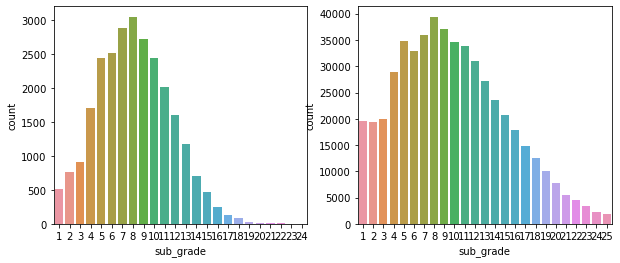

In [200]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
sns.countplot(x=fails['sub_grade'],ax=ax1)
sns.countplot(x=Xtest['sub_grade'],ax=ax2)

(0.0, 40.0)

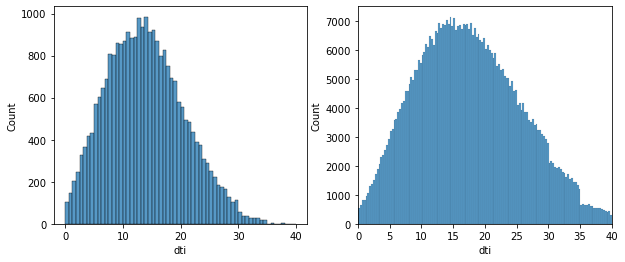

In [201]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="dti", ax=ax1)
sns.histplot(data=Xtest, x="dti", ax=ax2)
plt.xlim(0, 40)
# plt.show()

<AxesSubplot:xlabel='int_rate', ylabel='Count'>

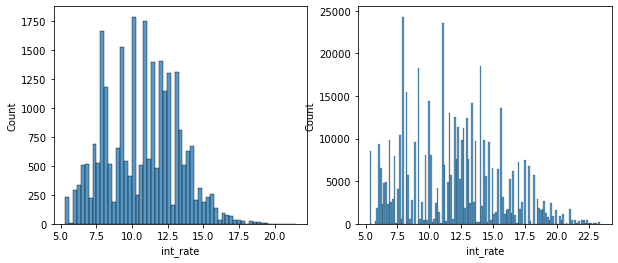

In [202]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="int_rate", ax=ax1)
sns.histplot(data=Xtest, x="int_rate", ax=ax2)

<AxesSubplot:xlabel='emp_length', ylabel='Count'>

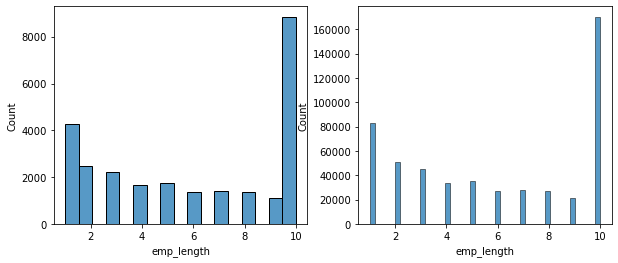

In [203]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="emp_length", ax=ax1)
sns.histplot(data=Xtest, x="emp_length", ax=ax2)

<AxesSubplot:xlabel='fico_score_average', ylabel='Count'>

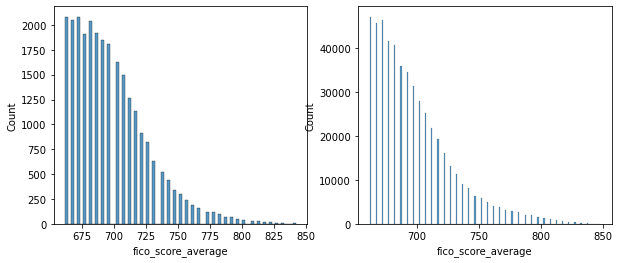

In [204]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="fico_score_average", ax=ax1)
sns.histplot(data=Xtest, x="fico_score_average", ax=ax2)

<AxesSubplot:xlabel='open_acc', ylabel='Count'>

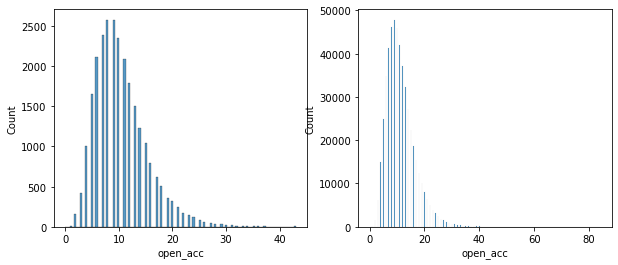

In [206]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(data=fails, x="open_acc", ax=ax1)
sns.histplot(data=Xtest, x="open_acc", ax=ax2)

### change the threshold to improve the pred_1 precision

In [31]:
probs_positive_class = best_model.predict_proba(Xtest)[:, 1]
prediction = probs_positive_class > .6

In [32]:
cmat2 = confusion_matrix(ytest, prediction, labels=[0, 1])
pd.DataFrame(cmat2, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])

,Pred_0,Pred_1
True_0,60518,8620
True_1,317610,132956


In [33]:
from sklearn.metrics import classification_report
print(classification_report(ytest, prediction))

              precision    recall  f1-score   support

           0       0.16      0.88      0.27     69138
           1       0.94      0.30      0.45    450566

    accuracy                           0.37    519704
   macro avg       0.55      0.59      0.36    519704
weighted avg       0.84      0.37      0.43    519704



In [34]:
cmat=cmat2
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

loan approval rate: 0.27
precision pred_1: 0.94
recall pred_1: 0.30


### Loop to check thresholds

In [35]:
thresholds = np.linspace(0.5,1,19)

for i in thresholds:
    probs_positive_class = best_model.predict_proba(Xtest)[:, 1]
    prediction = probs_positive_class > i
    cmat = confusion_matrix(ytest, prediction, labels=[0, 1])
    print(f'threshold:{i:.2f}')
    print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
    print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
    print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')
    print("-"*50)

threshold:0.50
loan approval rate: 0.58
precision pred_1: 0.91
recall pred_1: 0.61
--------------------------------------------------
threshold:0.53
loan approval rate: 0.47
precision pred_1: 0.92
recall pred_1: 0.50
--------------------------------------------------
threshold:0.56
loan approval rate: 0.39
precision pred_1: 0.93
recall pred_1: 0.41
--------------------------------------------------
threshold:0.58
loan approval rate: 0.31
precision pred_1: 0.94
recall pred_1: 0.34
--------------------------------------------------
threshold:0.61
loan approval rate: 0.25
precision pred_1: 0.94
recall pred_1: 0.27
--------------------------------------------------
threshold:0.64
loan approval rate: 0.19
precision pred_1: 0.94
recall pred_1: 0.21
--------------------------------------------------
threshold:0.67
loan approval rate: 0.15
precision pred_1: 0.95
recall pred_1: 0.17
--------------------------------------------------
threshold:0.69
loan approval rate: 0.12
precision pred_1: 0.95

## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
# predict probabilities
yhat = logr.predict_proba(Xtest)

In [ ]:
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

In [ ]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, prediction)

In [ ]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### SGD classifier

### Save model in pickle

In [ ]:
filename = 'grid_logr_model.sav'
pickle.dump(grid_logr, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xtest, ytest)
print(result)